# Analyse Interval Analysis

In [12]:
from pathlib import Path
import pandas as pd
from matplotlib import pyplot as plt
import re

Run with `dakota -i ia.in`.

In [13]:
# Remove LHS* files
lhs_paths = Path.cwd().glob("LHS*")
for lhs_path in lhs_paths:
    lhs_path.unlink()

In [14]:
# Collect interval results (w response) and constraint numbers that are min and max w
out_paths = ["ia_lt_8p.out", "ia_lt_max_net_elec_8p.out"]
# out_paths = ["ia_lt_1p.out"]  # testing
intervals = {"design": [], "min": [], "max": [], "min_con_id": [], "max_con_id": []}
design_names = {
    # "ia_lt_1p": "test",
    "ia_lt_8p": "min $R_{major}$",
    "ia_lt_max_net_elec_8p": "max $P^{net}_{elec}$",
}
con_ids = {
    13: "Burn time lower limit",
    15: "L-H power threshold limit",
    16: "Net electric power lower limit",
    34: "TF coil dump voltage upper limit (SCTF)",
}
min_max_re = re.compile(r"w:\s+Min\s=\s(\d\.\d+e[+-]\d+)\s+Max\s=\s(\d\.\d+e[+-]\d+)")
w_con_id_re = re.compile(r"\s+(\d\.\d+e[+-]\d+)\s+w\n\s+\s(\d\.\d+e[+-]\d+)\sw_con_id")
for results_path in [Path(out_path) for out_path in out_paths]:
    # Extract min and max
    with open(results_path, "r") as f:
        # Might be a problem with huge files? Seems alright
        text = f.read()

    # Find min and max values of w (in results summary)
    min_max_matches = min_max_re.search(text)
    min = min_max_matches[1]
    max = min_max_matches[2]

    # Now find constraint id corresponding to w
    # Finds all w values and their corresponding con ids (numbers)
    w_con_id_matches = w_con_id_re.findall(text)
    for w_con_id_match in w_con_id_matches:
        if w_con_id_match[0] == min:
            # min w con id
            min_con_id = int(float(w_con_id_match[1]))
        elif w_con_id_match[0] == max:
            # max w con id
            max_con_id = int(float(w_con_id_match[1]))

    # Aggregate data for df
    intervals["design"].append(design_names[results_path.stem])
    intervals["min"].append(float(min))
    intervals["max"].append(float(max))
    intervals["min_con_id"].append(con_ids[min_con_id])
    intervals["max_con_id"].append(con_ids[max_con_id])

df = pd.DataFrame(intervals)
col_map = {
    "design": "Design",
    "min": "LB",
    "max": "UB",
    "min_con_id": "LB constraint",
    "max_con_id": "UB constraint",
}
df = df.rename(columns=col_map)
df

,Design,LB,UB,LB constraint,UB constraint
0,min $R_{major}$,0.088949,5.234854,Net electric power lower limit,L-H power threshold limit
1,max $P^{net}_{elec}$,0.005224,153115.247910,TF coil dump voltage upper limit (SCTF),L-H power threshold limit


In [15]:
df.to_latex(
    "w_intervals.tex",
    float_format="%.2e",
    index=False,
    # column_format="llrrp{0.45\linewidth}",
)

KeyError: 'design'

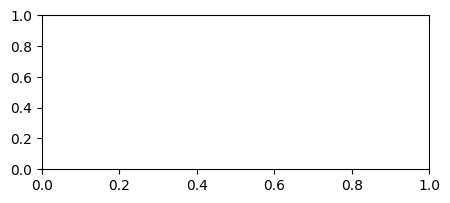

In [16]:
# Custom plot
fig, ax = plt.subplots(figsize=(5, 2.0))
for i, row in df.iterrows():
    ax.hlines(
        y=row["design"],
        xmin=row["min"],
        xmax=row["max"],
        color=f"C{i}",
        linewidth=10,
    )

ax.set_xlabel("$w$, worst-violated constraint")
ax.set_title(
    "Response intervals of the worst-violated constraint $w$ for two\nlarge tokamak design points under 8 uncertain parameters"
)
ax.margins(y=0.5)
ax.set_xscale("symlog")
ax.axvline(x=0.0, linestyle="--", color="grey")
ax.annotate("Safe", xy=(-0.4, -0.8), rotation=90, size=8, color="g")
ax.annotate("Failure", xy=(0.2, -0.8), rotation=90, size=8, color="r")
plt.savefig("ia.pdf", bbox_inches="tight")